In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

/home/jcolen/envs/sociohydro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
G_s, X_s, Y_s = [], [], []

with h5py.File(f'models/CensusPBNN_new_validation_saliency.h5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            gs = cs['G_S']
            keys = list(gs.keys())
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X']))
            Y_s.append(cs['Y'] - np.mean(cs['Y']))
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342)
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144)
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150)
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235)


170.50000000000045 169.00000000000003


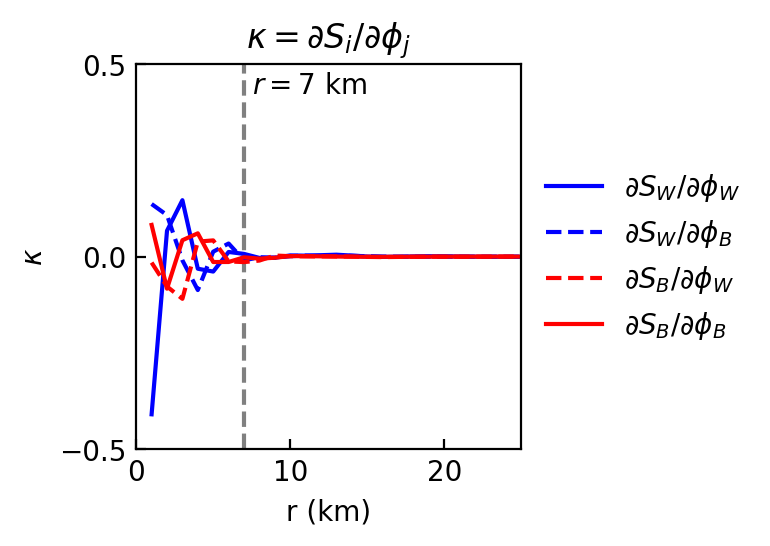

In [36]:
from scipy.interpolate import RectBivariateSpline

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r)-1)
    for j in range(len(r)-1):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r[1:], gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(xmax, ymax)
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa$')
ax.set(
    xlim=[0, 25],
    ylim=[-0.5, 0.5],
    xticks=[0, 10, 20],
    yticks=[-0.5, 0, 0.5])
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 7
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.set_title('$\\kappa = \\partial S_i / \\partial \\phi_j$')
ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5])

170.50000000000045 169.00000000000003


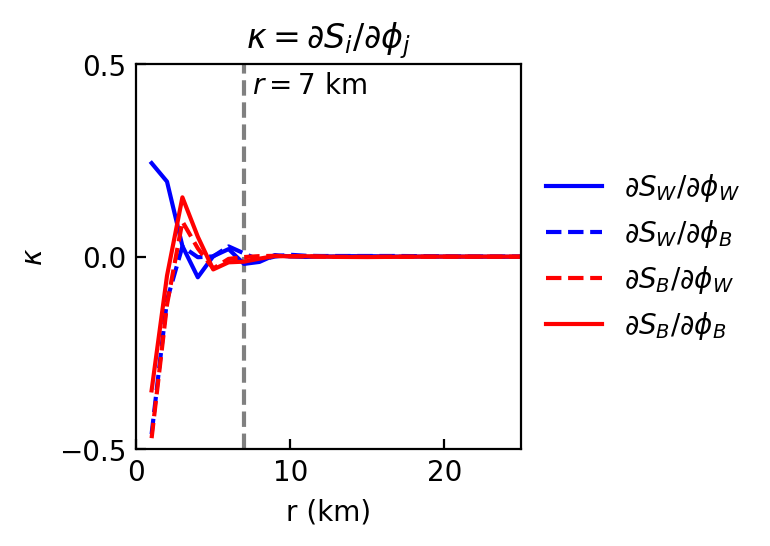

In [20]:
from scipy.interpolate import RectBivariateSpline

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r)-1)
    for j in range(len(r)-1):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        #gr[j] = np.mean(Gr[(rgrid>=r[j])*(rgrid<r[j+1])])
        
    return r[1:], gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(xmax, ymax)
x = np.linspace(-xmax, xmax, 400)#200)
y = np.linspace(-ymax, ymax, 400)#200)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa$')
ax.set(
    xlim=[0, 25],
    ylim=[-0.5, 0.5],
    xticks=[0, 10, 20],
    yticks=[-0.5, 0, 0.5])
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 7
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.set_title('$\\kappa = \\partial S_i / \\partial \\phi_j$')
ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5])